### 타이타닉 생존자 예측 예제(LSTM)

In [ ]:
# 사전 라이브러리 설치(XAI용, XAI: 실현가능한 AI) : pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer    # 결측치를 처리하는데 사용
from sklearn.preprocessing import LabelEncoder    #범주형 데이터를 숫자형 데이터로 변환하는 데 사용
import shap    # feature importance와 유사 (LSTM에 사용)

In [103]:
# 1. 데이터 로드 및 전처리
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = "{:.2f}".format

train_df = pd.read_csv('dataset/train_titanic.csv')
test_df = pd.read_csv('dataset/test_titanic.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [104]:
# 데이터 확인
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [105]:
# 결측치 확인
print(train_df.isnull().sum())
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          688
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [106]:
# 불필요한 컬럼 제거 (원핫 인코딩 없이도 잘 작동하도록)
train_df = train_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test_df = test_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

In [107]:
# Label Encoding (Sex 컬럼)
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])    # train 데이터 기준으로 transform
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.00,1,0,7.25,S
1,1,1,0,38.00,1,0,71.28,C
2,1,3,0,26.00,0,0,7.92,S
3,1,1,0,35.00,1,0,53.10,S
4,0,3,1,35.00,0,0,8.05,S


In [108]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.50,0,0,7.83,Q
1,3,0,47.00,1,0,7.00,S
2,2,1,62.00,0,0,9.69,Q
3,3,1,27.00,0,0,8.66,S
4,3,0,22.00,1,1,12.29,S


In [109]:
# Embarked 컬럼 처리 (최빈값으로 채우기)
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

In [110]:
# Label Encoding (Embarked 컬럼)
le_emb = LabelEncoder()
train_df['Embarked'] = le_emb.fit_transform(train_df['Embarked'])
test_df['Embarked'] = le_emb.transform(test_df['Embarked']) # train 데이터 기준으로 transform

In [111]:
# Age 컬럼 결측치 처리 (평균으로 채우기)
imputer = SimpleImputer(strategy='mean')
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])

In [112]:
# Fare 컬럼 결측치 처리 (평균으로 채우기)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())    # test 데이터에만 Fare 결측치 존재

In [113]:
# 전처리 후 데이터 확인
print(train_df.shape)
print(test_df.shape)

(891, 8)
(418, 7)


In [114]:
# 데이터 컬럼 확인
print("Train Columns:",train_df.columns.tolist())
print("Test Columns:",test_df.columns.tolist())

Train Columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Test Columns: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [115]:
# 스케일링 (MinMaxScaler)
scaler = MinMaxScaler()
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [ ]:
# 피처 수 확인
n_feature = X.shape[1]
print("피처수: ", n_feature)

피처수:  7


In [117]:
X = scaler.fit_transform(X)
test_df_scaled = scaler.transform(test_df)

In [118]:
# 특성 이름 저장 (SHAP 시각화에 사용)
feature_names = train_df.drop('Survived', axis=1).columns.tolist()
print(feature_names)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [119]:
# train, validation set 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
# 데이터 형태 확인
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("test_data:", test_df_scaled.shape)

X_train: (712, 7)
X_val: (179, 7)
test_data: (418, 7)


In [121]:
# LSTM 입력을 위한 reshape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0],1,n_feature)
X_val = X_val.reshape(X_val.shape[0],1,n_feature)
test_df_scaled = test_df_scaled.reshape(test_df_scaled.shape[0],1,n_feature)

In [ ]:
# 2. LSTM 모델 구축
model = Sequential([
    LSTM(64, input_shape=(1,n_feature),return_sequences=True),
    Dropout(0.2),
    LSTM(32,return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\pythonEdu\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [124]:
# 모델 구조 확인
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# Early Stopping - verbose=1로 설정하여 진행상황 확인
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,    # 10번의 에폭 동안 개선이 없으면 학습 중단
    restore_best_weights=True,    #  가장 좋은 성능을 보였던 모델의 가중치(weights)를 복원
    verbose=1    # 중단 시 메시지 출력
)

In [126]:
# 3. 모델 훈련 - verbose=1로 설정하여 진행상황 확인
epochs = 100
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_val,y_val),
    callbacks = [early_stop],
    verbose = 1     # 훈련 진행상황 출력
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6361 - loss: 0.6855 - val_accuracy: 0.5866 - val_loss: 0.6711
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6196 - loss: 0.6585 - val_accuracy: 0.5866 - val_loss: 0.6399
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6239 - loss: 0.6196 - val_accuracy: 0.5866 - val_loss: 0.6139
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6223 - loss: 0.6011 - val_accuracy: 0.5866 - val_loss: 0.5940
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6289 - loss: 0.5733 - val_accuracy: 0.6313 - val_loss: 0.5704
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6928 - loss: 0.5280 - val_accuracy: 0.7207 - val_loss: 0.5489
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7536 - loss: 0.5358 - val_accuracy: 0.7598 - val_loss: 0.5287
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7937 - loss: 0.5167 - val_accuracy: 0.7765 - 

In [127]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print("학습완료", actual_epochs, "번째")

학습완료 60 번째


In [128]:
# 4. 예측 및 평가
# Validation set 평가
y_pred_val_proba = model.predict(X_val, verbose=0)
y_pred_val = (y_pred_val_proba > 0.5).astype(int)    # 0.5를 기준으로 분류, astype(int) : True는 1로, False는 0

In [129]:
# 테스트 데이터 예측
y_pred_proba = model.predict(test_df_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)    # 0.5를 기준으로 분류, astype(int) : True는 1로, False는 0

In [130]:
# ROC Curve 및 AUC 계산 (Validation set)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

In [131]:
# Confusion Matrix (Validation set)
cm = confusion_matrix(y_val,y_pred_val)
print("Confusion Matrix :\n", cm)

Confusion Matrix :
 [[92 13]
 [23 51]]


In [132]:
# Classification Report (Validation set)
print("Classification Report:\n",classification_report(y_val,y_pred_val))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



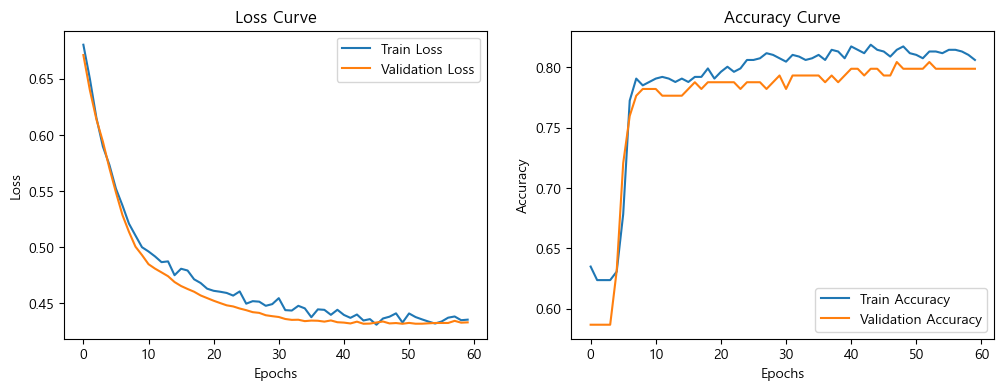

In [133]:
# 5. 결과 시각화 및 통계 분석
# 학습 곡선 시각화 (loss, accuracy)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

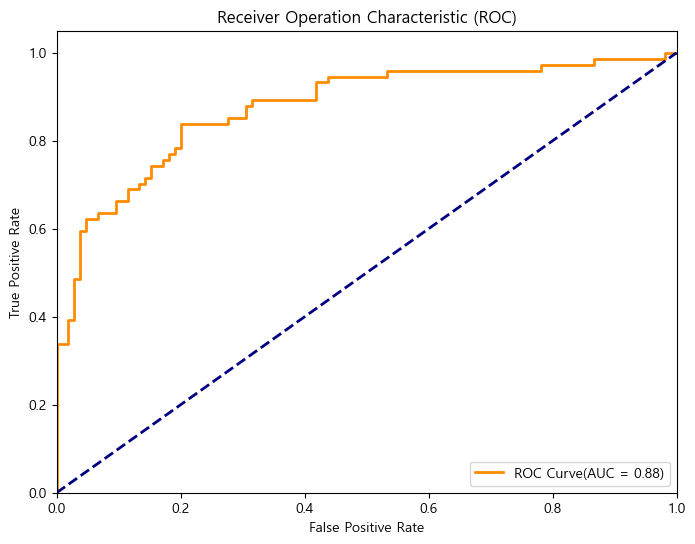

In [134]:
# ROC Curve 시각화 (Validation set)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve(AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operation Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

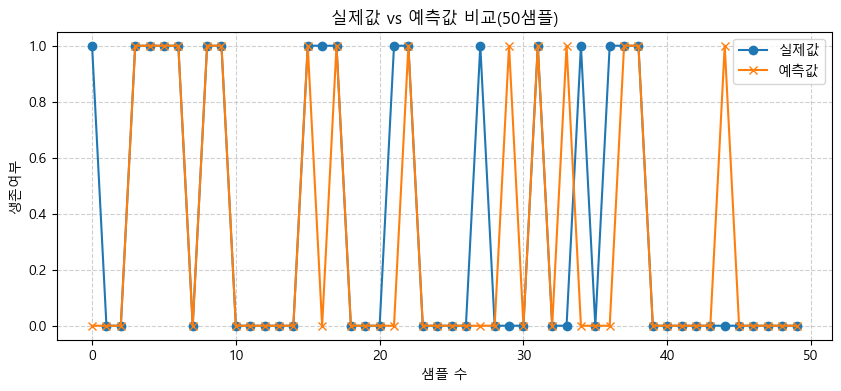

In [135]:
# 실제값 vs 예측값 시각화 (Validation set - 처음 30개 샘플)
plt.figure(figsize=(10,4))
plt.plot(y_val[:50].values, label='실제값', marker='o')
plt.plot(y_pred_val[:50].flatten(), label='예측값', marker='x')
plt.title("실제값 vs 예측값 비교(50샘플)")
plt.xlabel('샘플 수')
plt.ylabel('생존여부')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

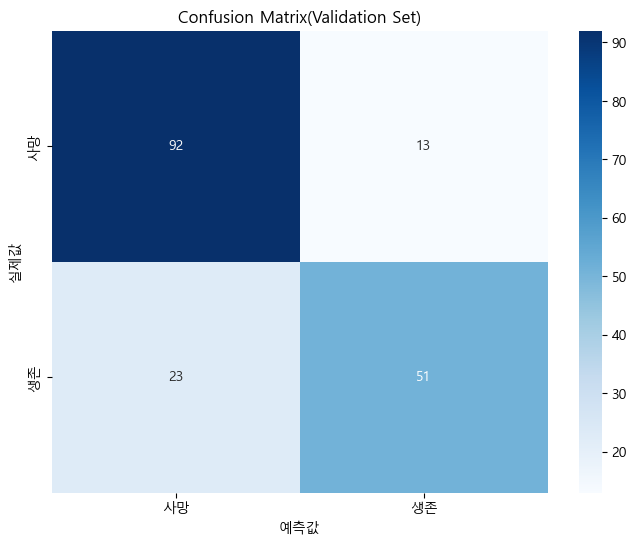

In [136]:
# Confusion Matrix 시각화 (Validation set)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['사망','생존'], yticklabels=['사망','생존'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix(Validation Set)')
plt.show()

In [137]:
# 6. 예측 결과 저장 (개선된 버전)
# test_titanic.csv에서 직접 PassengerId 가져오기
original_test_df = pd.read_csv('dataset/test_titanic.csv')
passenger_ids = original_test_df['PassengerId']

In [138]:
# 예측 결과와 PassengerId를 합쳐 새로운 DataFrame 생성
forcast_results = pd.DataFrame({
    'PassengerId' : passenger_ids,
    'Survived': y_pred.flatten()    # flatten()으로 1차원 배열로 변환
})

In [139]:
# 결과 확인
print(forcast_results)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [142]:
# 결과를 CSV 파일로 저장
forcast_results.to_csv('dataset/forcast_titanic.csv', index=False)
print("저장 완료!")

저장 완료!


In [143]:
# 7. 모델 저장 (선택 사항)
model.save('model/titanic_lstm_model.h5')
print("모델 저장 완료!")

모델 저장 완료!


#### 타이타닉 생존자 예측 탐색적 데이터 분석 EDA (Exploratory Data Analysis)

In [144]:
# 원본 데이터를 로드
train_df_viz = pd.read_csv("dataset/train_titanic.csv")

C:\Users\human-16\AppData\Local\Temp\ipykernel_13344\3929814363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_df_viz, palette='viridis')


Text(0, 0.5, '인원 수')

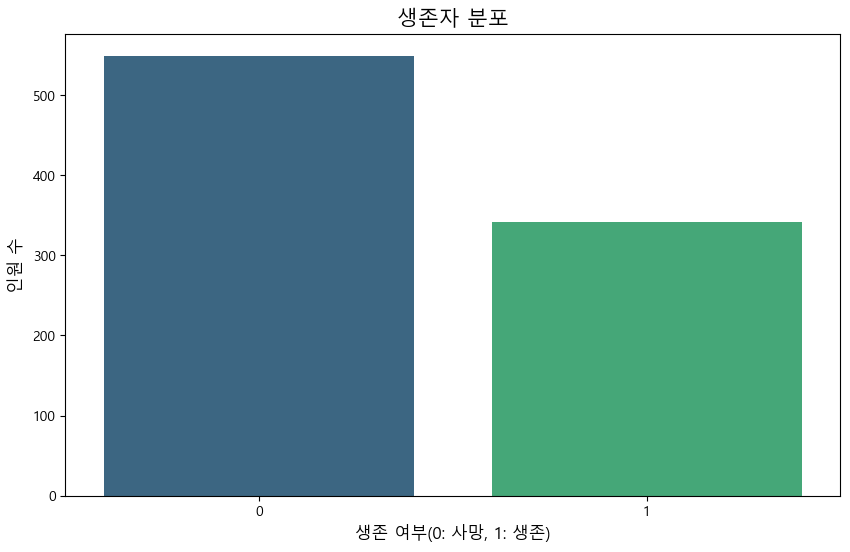

In [146]:
# 생존자 분포 확인
plt.figure(figsize=(10,6))
sns.countplot(x='Survived', data=train_df_viz, palette='viridis')
plt.title('생존자 분포', fontsize=15)
plt.xlabel("생존 여부(0: 사망, 1: 생존)", fontsize=12)
plt.ylabel('인원 수',fontsize=12)

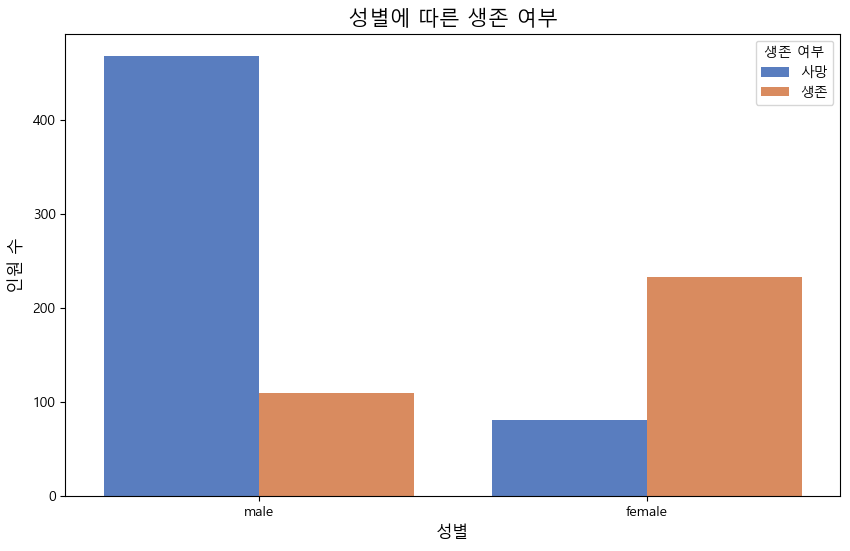

In [148]:
# 성별과 생존 관계
plt.figure(figsize=(10,6))
sns.countplot(x='Sex', hue='Survived', data=train_df_viz, palette='muted')
plt.title('성별에 따른 생존 여부', fontsize=15)
plt.xlabel("성별", fontsize=12)
plt.ylabel('인원 수',fontsize=12)
plt.legend(title='생존 여부', labels=['사망','생존'])

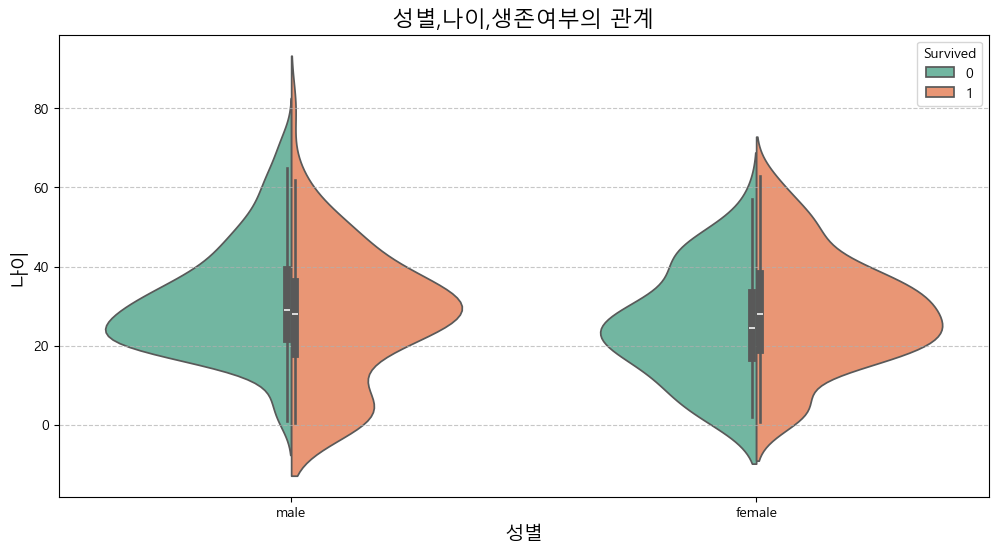

In [150]:
# 나이, 성별, 생존 관계를 보여주는 바이올린 플롯
plt.figure(figsize=(12,6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df_viz.dropna(subset=['Age']), split=True, palette='Set2')
plt.title('성별,나이,생존여부의 관계', fontsize=16)
plt.xlabel('성별', fontsize=14)
plt.ylabel('나이', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1200x600 with 0 Axes>

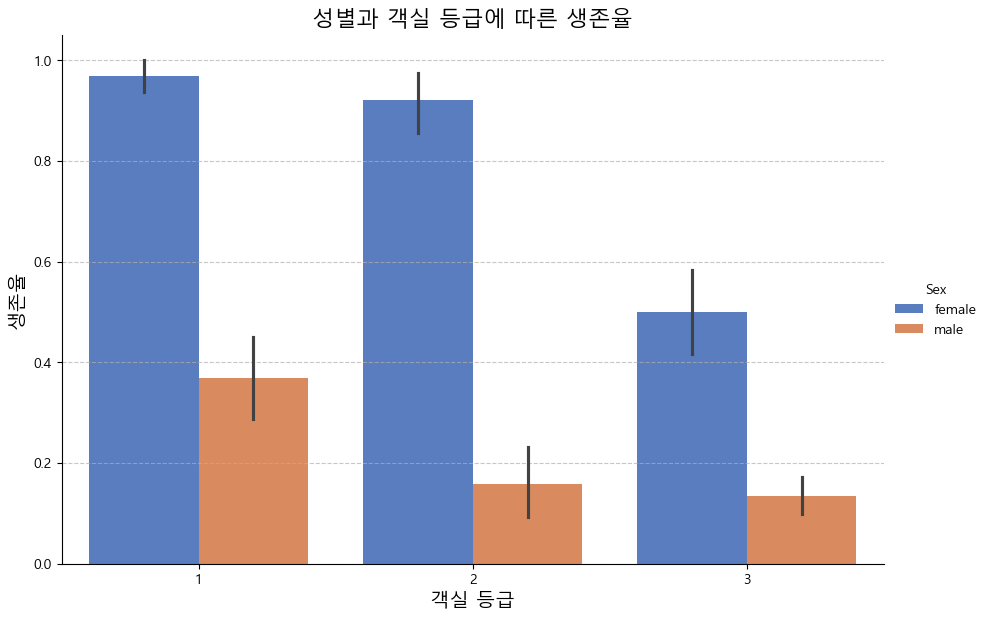

In [151]:
# 성별과 객실 등급에 따른 생존율 (인터랙션 효과) , 검은색 선은 오차
plt.figure(figsize=(12, 6))
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=train_df_viz, height=6, aspect=1.5, palette='muted')
plt.title('성별과 객실 등급에 따른 생존율', fontsize=16)
plt.xlabel('객실 등급', fontsize=14)
plt.ylabel('생존율', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

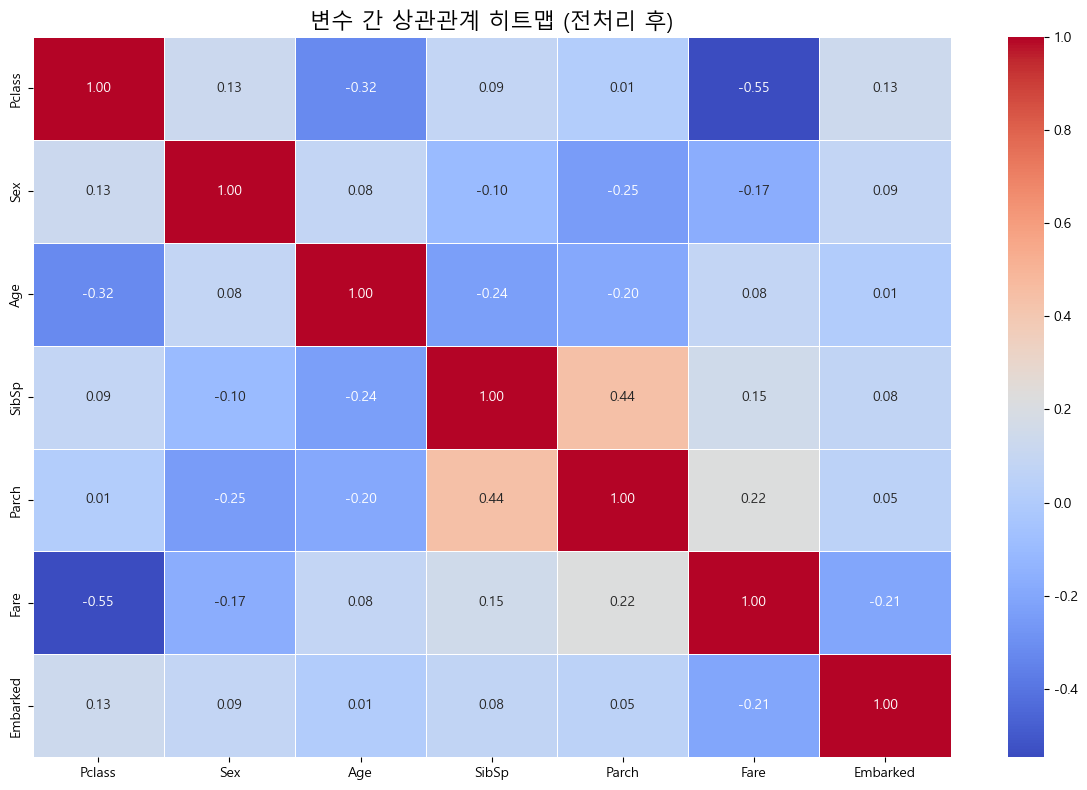

In [152]:
# 히트맵으로 변수 간 상관관계 확인 (전처리된 데이터 사용)
plt.figure(figsize=(12, 8))
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[2]), columns=train_df.drop('Survived', axis=1).columns)

# 상관계수 행렬 계산
corr_matrix = X_train_df.corr()
# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('변수 간 상관관계 히트맵 (전처리 후)', fontsize=16)
plt.tight_layout()
plt.show()

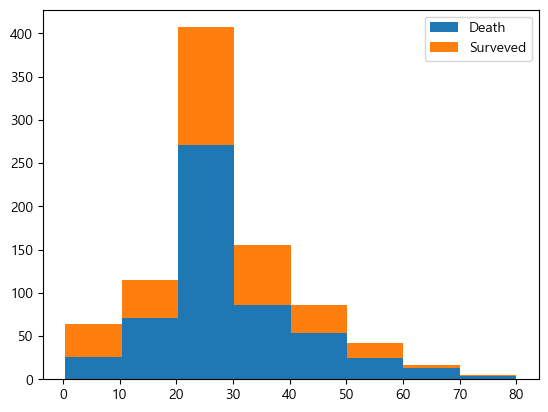

In [153]:
# 연령별 생존률
plt.hist(x=[train_df.Age[train_df.Survived==0], train_df.Age[train_df.Survived==1]], bins=8, histtype='barstacked', label=['Death', 'Surveved'])
plt.legend()

특성 이름: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_sample 형태: (100, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  1%|          | 1/100 [00:00<00:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  2%|▏         | 2/100 [00:00<00:23,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  3%|▎         | 3/100 [00:00<00:21,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 4/100 [00:00<00:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  5%|▌         | 5/100 [00:01<00:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  6%|▌         | 6/100 [00:01<00:20,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  7%|▋         | 7/100 [00:01<00:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 8/100 [00:01<00:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  9%|▉         | 9/100 [00:01<00:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|█         | 10/100 [00:02<00:18,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 11/100 [00:02<00:18,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 12/100 [00:02<00:18,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 13/100 [00:02<00:17,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 14/100 [00:02<00:17,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▌        | 15/100 [00:03<00:17,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 16/100 [00:03<00:17,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 17/100 [00:03<00:17,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 18/100 [00:03<00:16,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▉        | 19/100 [00:04<00:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|██        | 20/100 [00:04<00:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 21/100 [00:04<00:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 22%|██▏       | 22/100 [00:04<00:16,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 23%|██▎       | 23/100 [00:04<00:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 24/100 [00:05<00:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▌       | 25/100 [00:05<00:16,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 26/100 [00:05<00:16,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 27/100 [00:05<00:15,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 28/100 [00:05<00:15,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 29%|██▉       | 29/100 [00:06<00:14,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|███       | 30/100 [00:06<00:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 31%|███       | 31/100 [00:06<00:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 32/100 [00:06<00:14,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 33/100 [00:07<00:14,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 34/100 [00:07<00:15,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▌      | 35/100 [00:07<00:14,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 36%|███▌      | 36/100 [00:07<00:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 37/100 [00:07<00:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 38/100 [00:08<00:13,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▉      | 39/100 [00:08<00:13,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 40%|████      | 40/100 [00:08<00:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 41/100 [00:08<00:12,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 42%|████▏     | 42/100 [00:08<00:12,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 43/100 [00:09<00:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 44/100 [00:09<00:11,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▌     | 45/100 [00:09<00:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 46/100 [00:09<00:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 47%|████▋     | 47/100 [00:10<00:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 48/100 [00:10<00:10,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 49%|████▉     | 49/100 [00:10<00:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|█████     | 50/100 [00:10<00:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████     | 51/100 [00:10<00:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 52%|█████▏    | 52/100 [00:11<00:09,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 53%|█████▎    | 53/100 [00:11<00:09,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 54/100 [00:11<00:09,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▌    | 55/100 [00:11<00:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▌    | 56/100 [00:11<00:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 57/100 [00:12<00:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 58%|█████▊    | 58/100 [00:12<00:09,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 59%|█████▉    | 59/100 [00:12<00:08,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|██████    | 60/100 [00:12<00:08,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 61%|██████    | 61/100 [00:13<00:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 62%|██████▏   | 62/100 [00:13<00:08,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 63/100 [00:13<00:07,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 64/100 [00:13<00:07,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 65%|██████▌   | 65/100 [00:13<00:07,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 66/100 [00:14<00:07,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 67%|██████▋   | 67/100 [00:14<00:07,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 68/100 [00:14<00:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 69%|██████▉   | 69/100 [00:14<00:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 70%|███████   | 70/100 [00:14<00:06,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 71%|███████   | 71/100 [00:15<00:06,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 72/100 [00:15<00:06,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 73%|███████▎  | 73/100 [00:15<00:05,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 74%|███████▍  | 74/100 [00:15<00:05,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 75%|███████▌  | 75/100 [00:16<00:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 76%|███████▌  | 76/100 [00:16<00:05,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 77%|███████▋  | 77/100 [00:16<00:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 78/100 [00:16<00:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 79%|███████▉  | 79/100 [00:16<00:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 80%|████████  | 80/100 [00:17<00:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████  | 81/100 [00:17<00:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 82%|████████▏ | 82/100 [00:17<00:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 83%|████████▎ | 83/100 [00:17<00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 84/100 [00:17<00:03,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 85/100 [00:18<00:03,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 86/100 [00:18<00:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 87/100 [00:18<00:02,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 88/100 [00:18<00:02,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 89%|████████▉ | 89/100 [00:19<00:02,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|█████████ | 90/100 [00:19<00:02,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 91%|█████████ | 91/100 [00:19<00:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 92/100 [00:19<00:01,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 93%|█████████▎| 93/100 [00:20<00:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 94/100 [00:20<00:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 95%|█████████▌| 95/100 [00:20<00:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 96%|█████████▌| 96/100 [00:20<00:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 97/100 [00:20<00:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 98%|█████████▊| 98/100 [00:21<00:00,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 99%|█████████▉| 99/100 [00:21<00:00,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]

SHAP 값 형태: (100, 7)
특성별 중요도: [0.11266212 0.24299528 0.02397258 0.01980587 0.00795238 0.01386219
 0.02371045]


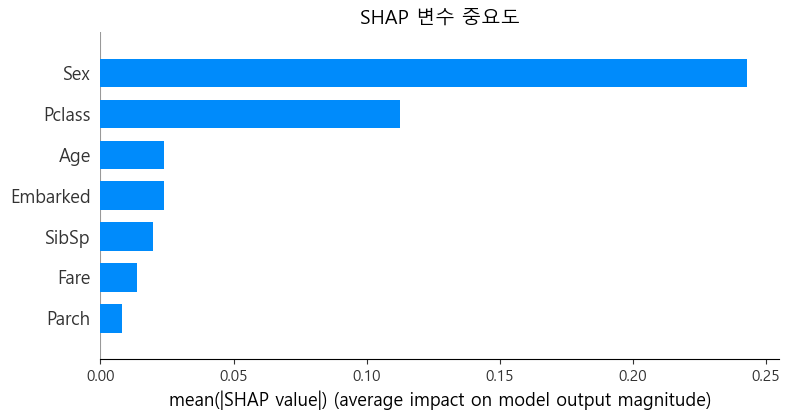

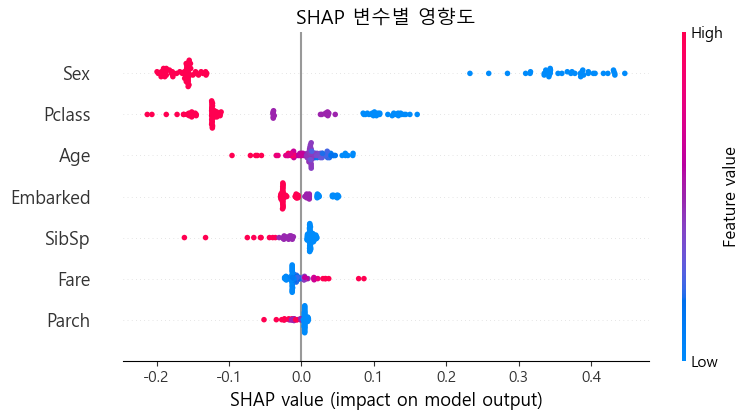

상위 3개 중요 특성: ['Sex', 'Pclass', 'Age']


<Figure size 1000x600 with 0 Axes>

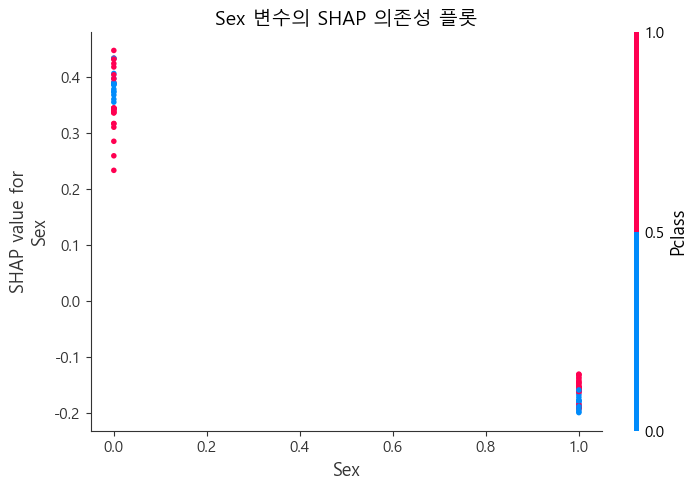

<Figure size 1000x600 with 0 Axes>

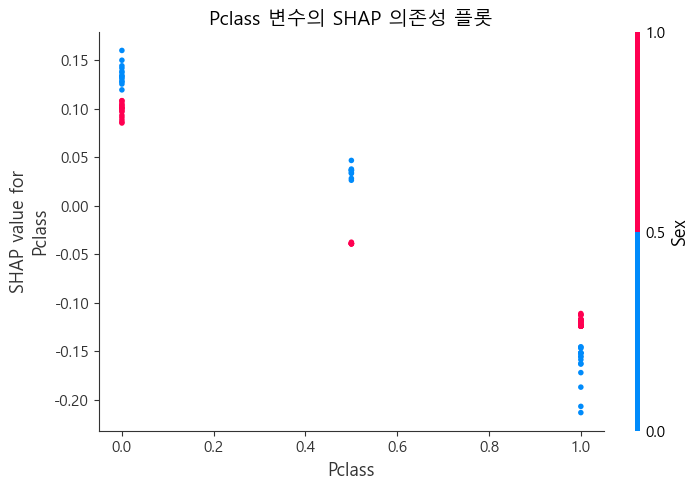

<Figure size 1000x600 with 0 Axes>

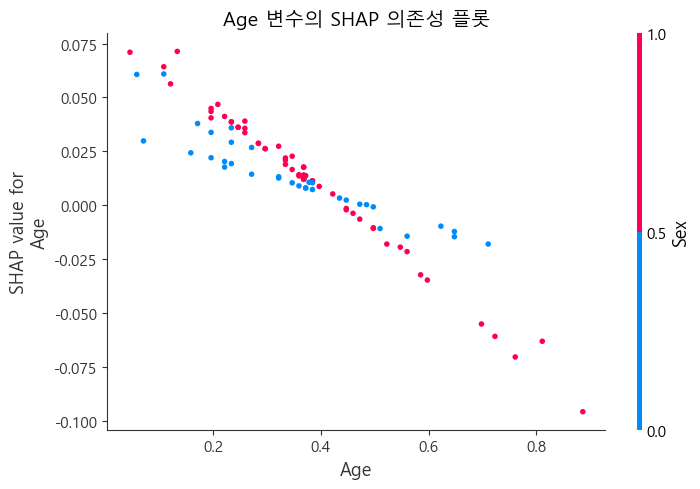

In [154]:
# SHAP 분석을 위한 함수 정의
def f(X):
    # SHAP은 원본 입력 형태를 요구하므로 LSTM 입력 형태로 변환
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
    return model.predict(X_reshaped).flatten()  # flatten()을 추가해 1차원 배열로 변환

# 원본 형태의 데이터로 SHAP 분석 준비 (시각화용 샘플 제한)
X_sample = X_val.reshape(X_val.shape[0], X_val.shape[2])
X_sample = X_sample[:100]  # 계산 시간 단축을 위해 100개 샘플만 사용

# 백그라운드 데이터 생성
background = shap.sample(X_sample, 10)  # 10개의 배경 데이터 샘플링

# 특성 이름 확인 (디버깅용)
print("특성 이름:", feature_names)
print("X_sample 형태:", X_sample.shape)

# SHAP 값 계산 (KernelExplainer 사용)
explainer = shap.KernelExplainer(f, background)
shap_values = explainer.shap_values(X_sample)

# 모든 특성을 강제로 표시하기 위한 설정
max_display = len(feature_names)  # 모든 특성 표시
print("SHAP 값 형태:", np.array(shap_values).shape)
print("특성별 중요도:", np.abs(shap_values).mean(0))

# Title이 포함된 그래프 생성 방식 수정
# 중요도 막대 그래프
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 plot_type="bar", show=False, max_display=max_display)
plt.title("SHAP 변수 중요도", fontsize=14)
plt.tight_layout()
plt.show()

# 변수별 영향도
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 show=False, max_display=max_display)
plt.title("SHAP 변수별 영향도", fontsize=14)
plt.tight_layout()
plt.show()

# 개별 변수 의존성 플롯 (상위 3개만)
# 중요도 순으로 특성 인덱스 정렬
importance = np.abs(shap_values).mean(0)
sorted_idx = np.argsort(-importance)
top_features = [feature_names[i] for i in sorted_idx[:3]]  # 상위 3개 특성

print("상위 3개 중요 특성:", top_features)

# 상위 특성에 대해서만 의존성 플롯 생성
for idx in sorted_idx[:3]:
    feature = feature_names[idx]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(idx, shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title(f"{feature} 변수의 SHAP 의존성 플롯", fontsize=14)
    plt.tight_layout()
    plt.show()

### 클러스터링 예제(k-means)

In [155]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [157]:
dataset = pd.read_csv('dataset/KMeansData.csv')
dataset.head()

,hour,score
0,7.33,73
1,3.71,55
2,3.43,55
3,3.06,89
4,3.33,79


In [159]:
X = dataset.iloc[:,:].values
print(X)

[[  7.33  73.  ]
 [  3.71  55.  ]
 [  3.43  55.  ]
 [  3.06  89.  ]
 [  3.33  79.  ]
 [  7.22  26.  ]
 [  8.12  15.  ]
 [  5.74  62.  ]
 [  8.73  59.  ]
 [  4.73  74.  ]
 [  5.    78.  ]
 [  2.63  46.  ]
 [  7.02   5.  ]
 [  3.45  38.  ]
 [  3.06  49.  ]
 [  4.13  66.  ]
 [  9.17  29.  ]
 [  7.61  74.  ]
 [  0.94  34.  ]
 [  3.67  71.  ]
 [  8.47   9.  ]
 [  2.86  67.  ]
 [  1.9   43.  ]
 [  6.08   0.  ]
 [  8.42  90.  ]
 [  6.12  77.  ]
 [  0.    47.  ]
 [  2.16  50.  ]
 [  2.24  38.  ]
 [  2.31  23.  ]
 [  8.03  31.  ]
 [  9.02   2.  ]
 [  2.43  20.  ]
 [  4.5   80.  ]
 [  8.66  70.  ]
 [  7.95  75.  ]
 [  2.03  26.  ]
 [  5.43  74.  ]
 [  4.44  78.  ]
 [  3.17  76.  ]
 [  1.53  42.  ]
 [  7.85  25.  ]
 [  7.42  85.  ]
 [  2.14  47.  ]
 [  2.02  36.  ]
 [  9.43  69.  ]
 [  7.94  22.  ]
 [  1.83  74.  ]
 [  7.6   23.  ]
 [  6.41  35.  ]
 [  7.21  94.  ]
 [  2.53  75.  ]
 [  7.75  16.  ]
 [  8.08  27.  ]
 [  4.61  62.  ]
 [  4.04  83.  ]
 [  4.25  61.  ]
 [  2.44  96.  ]
 [  2.06  51. 

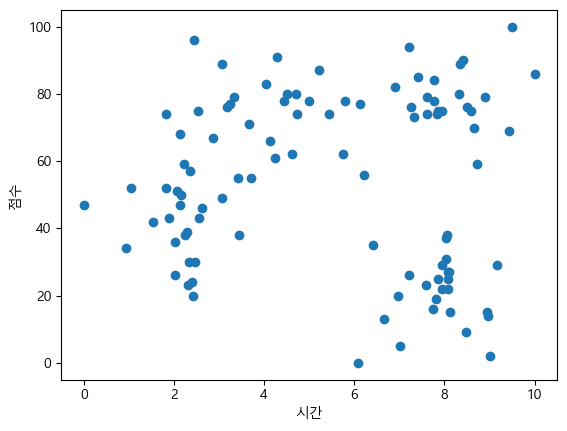

In [162]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel('시간')
plt.ylabel('점수')
plt.show()

In [163]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
print(X)

[[ 0.68729921  0.73538376]
 [-0.66687438  0.04198891]
 [-0.77161709  0.04198891]
 [-0.9100271   1.35173473]
 [-0.8090252   0.96651537]
 [ 0.64615029 -1.07514723]
 [ 0.98282328 -1.49888853]
 [ 0.09251026  0.31164246]
 [ 1.21101275  0.19607665]
 [-0.28531166  0.77390569]
 [-0.18430976  0.92799344]
 [-1.07088197 -0.30470851]
 [ 0.57133407 -1.88410788]
 [-0.76413547 -0.612884  ]
 [-0.9100271  -0.18914271]
 [-0.50976032  0.4657302 ]
 [ 1.37560843 -0.95958142]
 [ 0.79204192  0.77390569]
 [-1.70307903 -0.76697174]
 [-0.68183762  0.65833988]
 [ 1.11375166 -1.73002014]
 [-0.98484332  0.50425214]
 [-1.34396117 -0.42027432]
 [ 0.21969783 -2.07671756]
 [ 1.09504761  1.39025667]
 [ 0.23466107  0.8894715 ]
 [-2.05471527 -0.26618658]
 [-1.24670009 -0.15062077]
 [-1.2167736  -0.612884  ]
 [-1.19058792 -1.19071304]
 [ 0.94915598 -0.88253755]
 [ 1.31949627 -1.99967369]
 [-1.14569819 -1.30627885]
 [-0.37135031  1.00503731]
 [ 1.18482707  0.61981795]
 [ 0.91922949  0.81242763]
 [-1.29533063 -1.07514723]
 

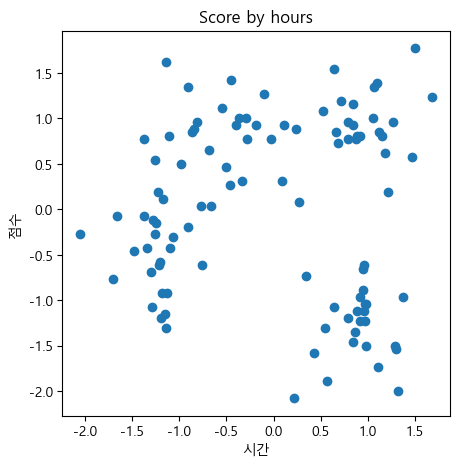

In [164]:
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('시간')
plt.ylabel('점수')
plt.show()

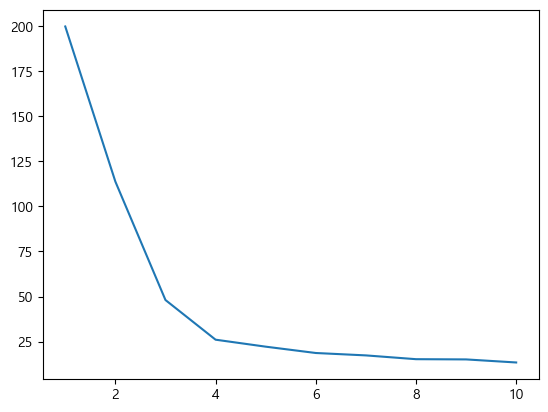

In [167]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1,11), inertia_list)
plt.show()

In [168]:
K=4
kmeans = KMeans(n_clusters=K,random_state=42)
y_kemeans = kmeans.fit_predict(X)

In [169]:
y_kemeans

array([3, 0, 1, 0, 0, 2, 2, 0, 3, 0, 0, 1, 2, 1, 1, 0, 2, 3, 1, 0, 2, 0,
       1, 2, 3, 0, 1, 1, 1, 1, 2, 2, 1, 0, 3, 3, 1, 0, 0, 0, 1, 2, 3, 1,
       1, 3, 2, 0, 2, 2, 3, 0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 3, 2,
       2, 0, 2, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 3, 2, 3, 2, 2, 3, 0, 1, 2,
       3, 1, 0, 2, 0, 3, 1, 0, 3, 0, 2, 1], dtype=int32)

In [171]:
centers = kmeans.cluster_centers_
centers

array([[-0.51419387,  0.79673351],
       [-1.24939347, -0.48807293],
       [ 0.8837666 , -1.26929779],
       [ 1.0010394 ,  0.97488971]])

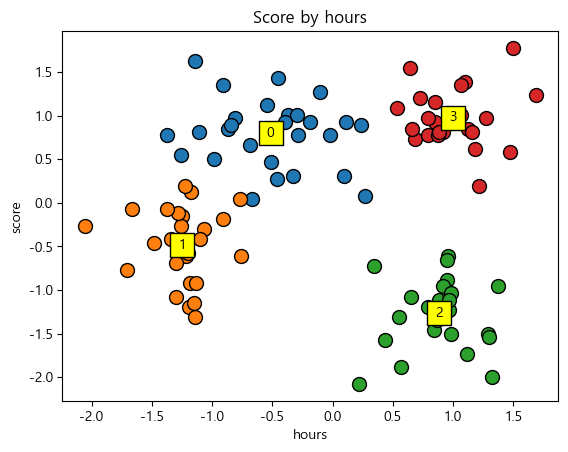

In [173]:
for cluster in range(K):
    plt.scatter(X[y_kemeans == cluster, 0], X[y_kemeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers[cluster, 0], centers[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

In [175]:
X_org = sc.inverse_transform(X)
X_org[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

In [176]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[ 4.11814815, 74.59259259],
       [ 2.1528    , 41.24      ],
       [ 7.8552    , 20.96      ],
       [ 8.16869565, 79.2173913 ]])

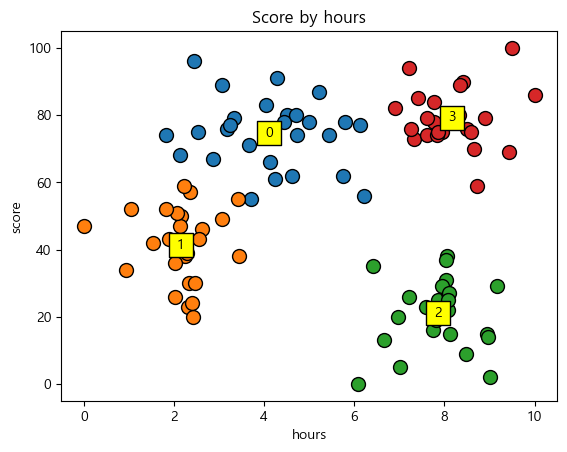

In [178]:
for cluster in range(K):
    plt.scatter(X_org[y_kemeans == cluster, 0], X_org[y_kemeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster, 0], centers_org[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers_org[cluster, 0], centers_org[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()